In [122]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

from xgboost import XGBRegressor

from scipy.stats import randint, uniform

# Spotify Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the popularity of a song based on its features.

The dataset contains a list of tracks with the following characteristics:
- `acousticness`: whether the track is acoustic
- `danceability`: describes how suitable a track is for dancing
- `duration_ms`: duration of the track in milliseconds
- `energy`: represents a perceptual measure of intensity and activity
- `explicit`: whether the track has explicit lyrics
- `id`: id for the track
- `instrumentalness`: predicts whether a track contains no vocals
- `key`: the key the track is in
- `liveness`: detects the presence of an audience in the recording
- `loudness`: the overall loudness of a track in decibels
- `mode`: modality of a track
- `name`: name of the track
- `popularity`: popularity of the track
- `release_date`: release date
- `speechiness`: detects the presence of spoken words in a track
- `tempo`: overall estimated tempo of a track in beats per minute
- `valence`: describes the musical positiveness conveyed by a track
- `artist`: artist who performed the track

# Model

## Data collection

**📝 Load the `spotify_popularity_train.csv` dataset from the provided URL. Display the first few rows. Perform the usual cleaning operations. Store the result in a `DataFrame` named `data`.**

👉 Do not forget to clean the dataset

In [2]:
url = "https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/spotify_popularity_train.csv"

In [3]:
data = pd.read_csv(url)
data.head(3)

acousticness  danceability  duration_ms  energy  explicit  \
0       0.65400         0.499       219827   0.190         0   
1       0.00592         0.439       483948   0.808         0   
2       0.73400         0.523       245693   0.288         0   

                       id  instrumentalness  key  liveness  loudness  mode  \
0  0B6BeEUd6UwFlbsHMQKjob           0.00409    7    0.0898   -16.435     1   
1  5Gpx4lJy3vKmIvjwbiR5c8           0.14000    2    0.0890    -8.497     1   
2  7MxuUYqrCIy93h1EEHrIrL           0.00000    0    0.0771   -11.506     1   

                                name  popularity release_date  speechiness  \
0            Back in the Goodle Days          40         1971       0.0454   
1  Worlds Which Break Us - Intro Mix          22   2015-02-02       0.0677   
2              I'm The Greatest Star          40   1968-09-01       0.2140   

     tempo  valence            artist  
0  149.460   0.4300     John Hartford  
1  138.040   0.0587         Driftmoon  
2   75.869   0.4640  Barbra Streisand

Let us have a look at potentially missing values. 

In [4]:
data.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
artist              4
dtype: int64

It seems that 4 songs do not display any artist. 

In [5]:
data[data['artist'].isnull()]

acousticness  danceability  duration_ms  energy  explicit  \
12850         0.517         0.613       191867   0.549         0   
17924         0.732         0.535       279600   0.435         0   
22383         0.758         0.376       189560   0.332         0   
32011         0.981         0.492       236733   0.286         0   

                           id  instrumentalness  key  liveness  loudness  \
12850  3NWCbI2VtW80g8cZG3QHIx            0.4440    7    0.0412    -7.648   
17924  0cSyeb33PyBMtLeUzCgDgO            0.2530    4    0.1190    -9.021   
22383  3gWhV34vWEBwguH0RP2w7j            0.0482    3    0.0766    -8.420   
32011  2nUaz5sLG0HccdACC1IG35            0.8920    3    0.1430    -8.966   

       mode                            name  popularity release_date  \
12850     1                      easy going           0         1935   
17924     0                concerto piccolo           0         1935   
22383     1            comfort ye my people           0         1935   
32011     1  i know that my redeemer liveth           0         1935   

       speechiness    tempo  valence artist  
12850       0.0327   83.967    0.583    NaN  
17924       0.0303  106.124    0.205    NaN  
22383       0.0296   91.840    0.260    NaN  
32011       0.0336   87.973    0.273    NaN

This can be put in relation with the overall number of observations in the dataset:

In [6]:
data.shape

(52317, 18)

Since `artist` is likely to be a variable of close interest in our modelling task, we are going to drop these 4 lines.

In [7]:
data.dropna(inplace=True)

Let us now check data types.

In [8]:
data.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
artist               object
dtype: object

The `release_date` is not a datetime object. We might want to make this change. Let us first look at the few release dates drawn randomly to check if they have the same format.

In [9]:
data['release_date'].sample(10)

5839           1968
29166    2020-04-15
3026     1954-01-01
28229    1997-06-17
43775    1997-04-18
48150          1965
14362    1940-11-22
27987    1945-02-01
40550    1990-01-01
37042    1993-11-15
Name: release_date, dtype: object

Sometimes, we have the full date and sometimes, we have only the year. But even when we have the full date, there are surprisingly many songs released on Jan. 1st, which could indicate that only the year is relevant in such a case and the day of the year is arbitrary. 

We are now changing the data type to datetime one, keeping in mind that mostly the year will be relevant.

In [10]:
data['release_date'] = pd.to_datetime(data['release_date'])

Let us run a quick check on categorical variables now:

In [11]:
data['key'].value_counts()

0     6604
7     6473
2     5752
9     5397
5     4845
1     4144
4     3909
10    3692
11    3373
8     3092
6     2813
3     2219
Name: key, dtype: int64

In [12]:
data['explicit'].value_counts()

0    48673
1     3640
Name: explicit, dtype: int64

In [13]:
data['mode'].value_counts()

1    36895
0    15418
Name: mode, dtype: int64

They do not display any weird values and we can now have a look to numerical features.

In [14]:
numerical_features = list(data.drop(columns=['id', 'artist', 'name', 'key', 'explicit', 'mode', 'release_date']).columns)

In [15]:
print('Number of numerical features in the dataset:', len(numerical_features))
print('List of numerical features in the dataset:', numerical_features)

Number of numerical features in the dataset: 11
List of numerical features in the dataset: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence']


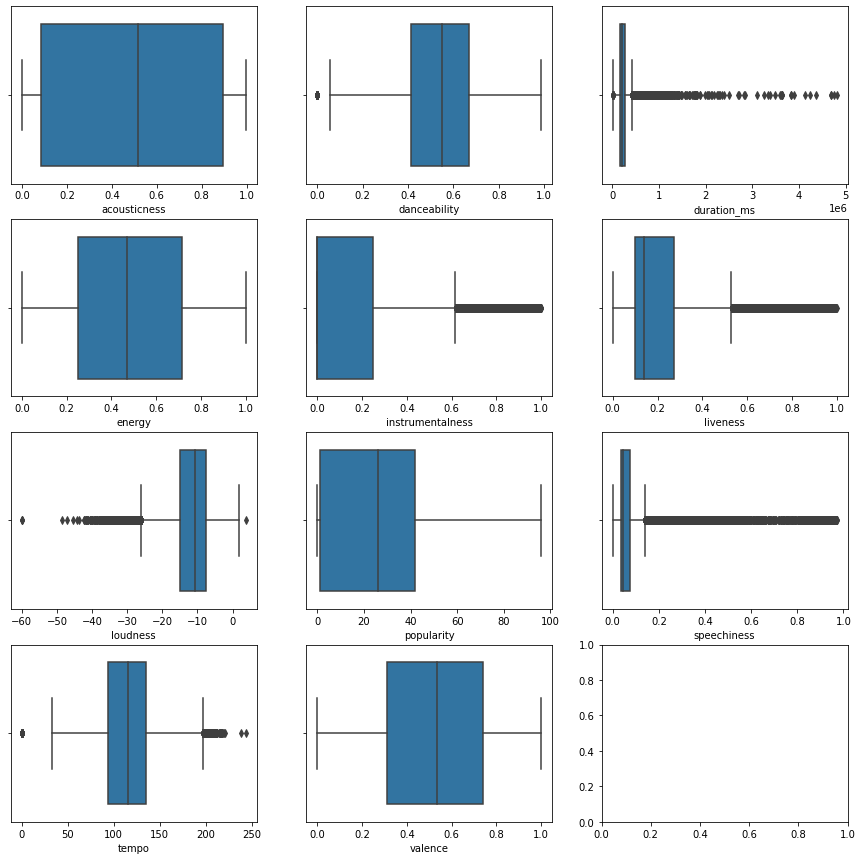

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

for feature_name, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(data[feature_name], ax=ax)

Let us focus on songs that display a close-to-0 `tempo` (number of beats per minute) which seems strange.

In [17]:
len(data[data['tempo'] < 10]), data[data['tempo'] < 10]['tempo'].sum()

(46, 0.0)

46 songs have a `tempo` of 0. This number is very small in comparison with the overall number of songs available and considering the wide distribution of values for this features, we make the simplifying choice of dropping these songs.

In [18]:
data = data[data['tempo'] > 0].copy()

In [19]:
data.shape

(52267, 18)

Finally, we might want to look for duplicates (inspired by weird results when displaying the 46 songs with 0 `tempo`).

In [20]:
data.drop_duplicates().shape

(52007, 18)

Indeed, there is a significant number of duplicates in the dataset! We can eliminate these:

In [21]:
data.drop_duplicates(inplace=True)

Let us control that the `id` is now unique for each observation.

In [22]:
# We check the count on the artist column but we could take any column
data.groupby('id').count()['artist'].max()

1

It seems that we have gone through most data cleaning steps, at least for a first quick process.

### Save your results

Run the following cell to save your results.

In [23]:
from nbresult import ChallengeResult

ChallengeResult(
    "c5_data_cleaning",
    data=data).write()

## Baseline

**📝 We want to use a metric that measures the prediction error in the same unit than `popularity`. In addition, it should strongly penalize largest errors. Which sklearn's [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use? Store its exact name as string below**

We can use the root mean squared error.

In [24]:
scoring = "Root Mean Squared Error (RMSE)"

We will use the `mean_squared_error` with `squared=False` from Scikit-Learn.

**📝 Let's build a baseline model using only the numerical features in our dataset.**
- Build `X_baseline` with only numerical features
- Build `y` your target containing the `popularity`
- Then 5 times cross validate the baseline linear model of your choice (do not fine tune it)
- Store your mean performance in a `float` variable named `baseline_score`

In [25]:
# We add categorical variables to the list of numerical features as they are already encoded
# (We could consider one-hot encoding key at some point, the determinant would be whether there is an ordering or not)
numerical_features += ['explicit', 'key']

X_baseline = data[numerical_features].drop(columns='popularity')

print(X_baseline.shape)

X_baseline.head()

(52007, 12)


acousticness  danceability  duration_ms  energy  instrumentalness  \
0       0.65400         0.499       219827   0.190          0.004090   
1       0.00592         0.439       483948   0.808          0.140000   
2       0.73400         0.523       245693   0.288          0.000000   
3       0.42900         0.681       130026   0.165          0.000000   
4       0.56200         0.543       129813   0.575          0.000004   

   liveness  loudness  speechiness    tempo  valence  explicit  key  
0    0.0898   -16.435       0.0454  149.460   0.4300         0    7  
1    0.0890    -8.497       0.0677  138.040   0.0587         0    2  
2    0.0771   -11.506       0.2140   75.869   0.4640         0    0  
3    0.3940   -21.457       0.9460  145.333   0.2880         0   11  
4    0.1270    -7.374       0.0265  139.272   0.8010         0    2

In [26]:
y = data['popularity']

In [27]:
lin_reg = LinearRegression()

cv_results = cross_validate(
    lin_reg,
    X_baseline, y,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [28]:
# We take the opposite to have a positive root mean squared error but it has no real impact
baseline_score = - cv_results['test_score'].mean()

print(baseline_score)

18.349551535391008


### Save your results

Run the following cell to save your results.

In [29]:
from nbresult import ChallengeResult

ChallengeResult(
    "baseline",
    scoring=scoring,
    baseline_score=baseline_score).write()

## Feature engineering

Let's now use the features that we left aside: `release_date` and `artist` to improve the performance of our model. We'll create them manually in a train vs. test context first (and pipeline them later)

### holdout
**📝 Create the 4 variables `X_train` `y_train`, `X_test`, `y_test` with a 50% split with random sampling**

In [30]:
# Compared with X_baseline, we add the song id to make sure the match with year will be correct
if 'id' not in numerical_features:
    numerical_features.append('id')

X = data[numerical_features].drop(columns='popularity')
y = data['popularity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [31]:
X_train.shape, y_train.shape

((26003, 13), (26003,))

In [32]:
X_test.shape, y_test.shape

((26004, 13), (26004,))

In [33]:
X_train.head()

acousticness  danceability  duration_ms  energy  instrumentalness  \
44381      0.439000         0.663       155067   0.389            0.0000   
9975       0.212000         0.604       299333   0.430            0.0000   
45205      0.010400         0.303       290960   0.968            0.0125   
39258      0.000037         0.280       284507   0.986            0.6880   
46727      0.152000         0.680       168640   0.589            0.0000   

       liveness  loudness  speechiness    tempo  valence  explicit  key  \
44381     0.129   -11.185       0.0303  138.207    0.619         0    9   
9975      0.159   -10.624       0.0356  126.632    0.574         0    3   
45205     0.935   -11.261       0.0666  130.997    0.318         0    1   
39258     0.071    -7.012       0.1150   91.025    0.160         0    0   
46727     0.378   -10.010       0.0247   93.865    0.696         0    0   

                           id  
44381  0JPY6qliLwFahjIcVvuHot  
9975   1srD2uc11TcQiOmHHrJp8M  
45205  1onZ5D8uw2K36DDZFDgR15  
39258  3eaOnliKh0QdjuDbPAwCLx  
46727  3nKLfeoq3YedJIZqvRW3Qz

### year

**📝 Create `X_train_year` and `X_test_year` by adding the new column `year` containing the release year of the track as integer**

In [34]:
X_train_year = X_train.merge(data[['id', 'release_date']], how='left', on='id')
X_test_year = X_test.merge(data[['id', 'release_date']], how='left', on='id')

X_train_year['release_date'] = X_train_year['release_date'].dt.year
X_test_year['release_date'] = X_test_year['release_date'].dt.year

X_train_year.head()

acousticness  danceability  duration_ms  energy  instrumentalness  \
0      0.439000         0.663       155067   0.389            0.0000   
1      0.212000         0.604       299333   0.430            0.0000   
2      0.010400         0.303       290960   0.968            0.0125   
3      0.000037         0.280       284507   0.986            0.6880   
4      0.152000         0.680       168640   0.589            0.0000   

   liveness  loudness  speechiness    tempo  valence  explicit  key  \
0     0.129   -11.185       0.0303  138.207    0.619         0    9   
1     0.159   -10.624       0.0356  126.632    0.574         0    3   
2     0.935   -11.261       0.0666  130.997    0.318         0    1   
3     0.071    -7.012       0.1150   91.025    0.160         0    0   
4     0.378   -10.010       0.0247   93.865    0.696         0    0   

                       id  release_date  
0  0JPY6qliLwFahjIcVvuHot          1985  
1  1srD2uc11TcQiOmHHrJp8M          1975  
2  1onZ5D8uw2K36DDZFDgR15          1986  
3  3eaOnliKh0QdjuDbPAwCLx          1984  
4  3nKLfeoq3YedJIZqvRW3Qz          1999

In [35]:
X_train_year.shape

(26003, 14)

### artist

How could we use the `artist` column? There are too many artists to one hot encode it.  
We could instead create an `artist_popularity` feature containing the mean popularity of an artist, computed as the mean popularity of all tracks the artist released _on the train set_.

#### Process artist popularity from the Training set

**📝 Compute and store the `artist_popularity` as a new pandas `Series`**  

In [36]:
X_train_year['popularity'] = y_train

X_train_year = X_train_year.merge(data[['id', 'artist']], on='id', how='left')

artist_popularity = X_train_year.groupby('artist').mean()['popularity']

global_mean_popularity = X_train_year['popularity'].mean()

X_train_year.drop(columns='popularity', inplace=True)

artist_popularity.head()

artist
"Test for Victor Young"     3.000000
"Weird Al" Yankovic        33.111111
$NOT                       72.000000
$uicideBoy$                67.666667
'Til Tuesday               27.000000
Name: popularity, dtype: float64

#### Apply the artist popularity to `X_train_year`

**📝 Create a new DataFrame `X_train_engineered` which adds a new column to the existing `X_train_year` with the `artist_popularity` corresponding to the song's artist.** 

🚨 Make sure that the target `popularity` does not end up in `X_train_engineered` 

In [37]:
artist_popularity = artist_popularity.reset_index()

X_train_engineered = X_train_year.merge(artist_popularity, on='artist', how='left').drop(columns=['artist', 'id'])

X_train_engineered.shape

(26003, 14)

In [38]:
X_train_engineered.head()

acousticness  danceability  duration_ms  energy  instrumentalness  \
0      0.439000         0.663       155067   0.389            0.0000   
1      0.212000         0.604       299333   0.430            0.0000   
2      0.010400         0.303       290960   0.968            0.0125   
3      0.000037         0.280       284507   0.986            0.6880   
4      0.152000         0.680       168640   0.589            0.0000   

   liveness  loudness  speechiness    tempo  valence  explicit  key  \
0     0.129   -11.185       0.0303  138.207    0.619         0    9   
1     0.159   -10.624       0.0356  126.632    0.574         0    3   
2     0.935   -11.261       0.0666  130.997    0.318         0    1   
3     0.071    -7.012       0.1150   91.025    0.160         0    0   
4     0.378   -10.010       0.0247   93.865    0.696         0    0   

   release_date  popularity  
0          1985   31.333333  
1          1975   31.800000  
2          1986   42.724138  
3          1984   38.135135  
4          1999   45.600000

#### Apply the artist popularity to `X_test_year`

**📝 Similarily, create a new DataFrame `X_test_engineered` which also adds a new column to the existing `X_test_year` with the `artist_popularity` corresponding to the song's artist, computed from the training set.**

🚨**If an artist has never been seen in the training set, use the global mean popularity of all the tracks of `X_train`**

In [39]:
X_test_engineered = X_test_year.merge(data[['id', 'artist']], on='id', how='left')

X_test_engineered = X_test_engineered.merge(artist_popularity, on='artist', how='left')

X_test_engineered.drop(columns=['id', 'artist'], inplace=True)

print(X_test_engineered.shape)

X_test_engineered.head()

(26004, 14)


acousticness  danceability  duration_ms  energy  instrumentalness  \
0      0.994000         0.557       167427   0.274          0.880000   
1      0.326000         0.577       196707   0.537          0.000079   
2      0.838000         0.493       164467   0.217          0.004630   
3      0.000014         0.389        71062   0.990          0.038800   
4      0.958000         0.453       288000   0.299          0.480000   

   liveness  loudness  speechiness    tempo  valence  explicit  key  \
0    0.4260   -11.913       0.0426  102.313   0.4120         0    9   
1    0.1910    -9.583       0.0372  152.528   0.4850         0    2   
2    0.0867   -11.501       0.0271  105.003   0.1820         0    9   
3    0.5830    -5.537       0.1010  135.982   0.0956         0   10   
4    0.1950   -16.289       0.0539  163.959   0.7990         0    5   

   release_date  popularity  
0          1943         NaN  
1          1997   54.000000  
2          1963   13.533333  
3          2020   13.000000  
4          1920    2.000000

In [40]:
X_test_engineered.isnull().sum()

acousticness           0
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
liveness               0
loudness               0
speechiness            0
tempo                  0
valence                0
explicit               0
key                    0
release_date           0
popularity          5049
dtype: int64

For 5046 observations of the test set, the artist could not be found in `artist_popularity` and we therefore need to impute a value to replace these NaNs.

In [41]:
X_test_engineered['popularity'] = X_test_engineered['popularity'].fillna(global_mean_popularity)

In [42]:
X_train_engineered.rename(columns={'popularity': 'artist_popularity'}, inplace=True)
X_test_engineered.rename(columns={'popularity': 'artist_popularity'}, inplace=True)

In [43]:
print(X_train_engineered.shape, y_train.shape)
print(X_test_engineered.shape, y_test.shape)

(26003, 14) (26003,)
(26004, 14) (26004,)


### Save your results

Run the following cell to save your results.

In [44]:
from nbresult import ChallengeResult

_ = pd.concat([X_train_engineered, X_test_engineered])

ChallengeResult("c7_feature_engineering",
    shape = _.shape,
    cols = _.columns,
    years = _.get("year"),
    popularities = _.get("artist_popularity"),
).write()

### Performance

**📝 Let's see how these features impact the performance of our model. Retrain the same baseline model on numerical values only, but adding the new features `year` and `artist_popularity`, and see how the performance is impacted. Save the performance in a `float` variable named `score_engineered`**

👉 Do not fine tune the model yet

In [45]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_engineered, y_train)

y_pred = lin_reg.predict(X_test_engineered)

score_engineered = mean_squared_error(y_test, y_pred, squared=False)

print(score_engineered)

14.25396418601126


### Save your results

Run the following cell to save your results.

In [46]:
from nbresult import ChallengeResult

ChallengeResult(
    "c7_score_engineering",
    scoring=scoring,
    score_engineered=score_engineered).write()

## Pipelining

**📝 Let's create a full sklearn preprocessing pipeline called `preproc`. It should integrate our feature engineering for `year` and `artist_popularity`, as well as any other preprocessing of your choice**

**Store also the number of columns/feature after preprocessing your inputs in a variable `col_number`**

**🚨⚠️ Advice: SKIP the `ArtistPopularityTransformer` if you don't have time to do it. It is better for you to have a working pipeline rather than NO pipeline at all**

In [61]:
# 👉 Do not hesitate to reload clean new dataset if you need a fresh start
data = pd.read_csv(url)

# We drop missing values and 0-tempo observations as before 
# (Not included in the pipeline as this affects both the X and the y)
data.dropna(inplace=True)
data = data[data['tempo'] > 0].copy()

y = data.popularity
X = data.drop("popularity", axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [63]:
# Run this cell to visualize your pipeline as you build it
from sklearn import set_config; set_config(display='diagram')

In [64]:
# We give you below the skeleton of the custom ArtistPopularityTransformer to complete

from sklearn.base import BaseEstimator, TransformerMixin

class ArtistPopularityTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        process artist mean popularity from artists songs popularity
        process song global mean popularity
        """
        
        if y is None:
            raise Exception("We need the y vector to compute artists' average popularity.")
            
        X = X.copy()
        
        X['popularity'] = y
        
        # process artist popularity
        self.artist_popularity = X.groupby('artist').mean()['popularity']
        
        # process mean popularity
        self.global_mean_popularity = y.mean()

        return self

    def transform(self, X, y=None):
        """
        apply artist mean popularity vs song global mean popularity to songs
        """

        # inject artist popularity and fills popularity of unknown artists with song global mean popularity
        X = X.copy()
        
        X['artist'] = X['artist'].map(
            lambda artist: self.artist_popularity.loc[artist] if artist in self.artist_popularity.index else self.global_mean_popularity
        )
        
        return X.copy()
        
    
class ReleaseYearTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        
        X['release_date'] = pd.to_datetime(X['release_date'])
        
        X['release_date'] = X['release_date'].dt.year
        
        return X.copy()

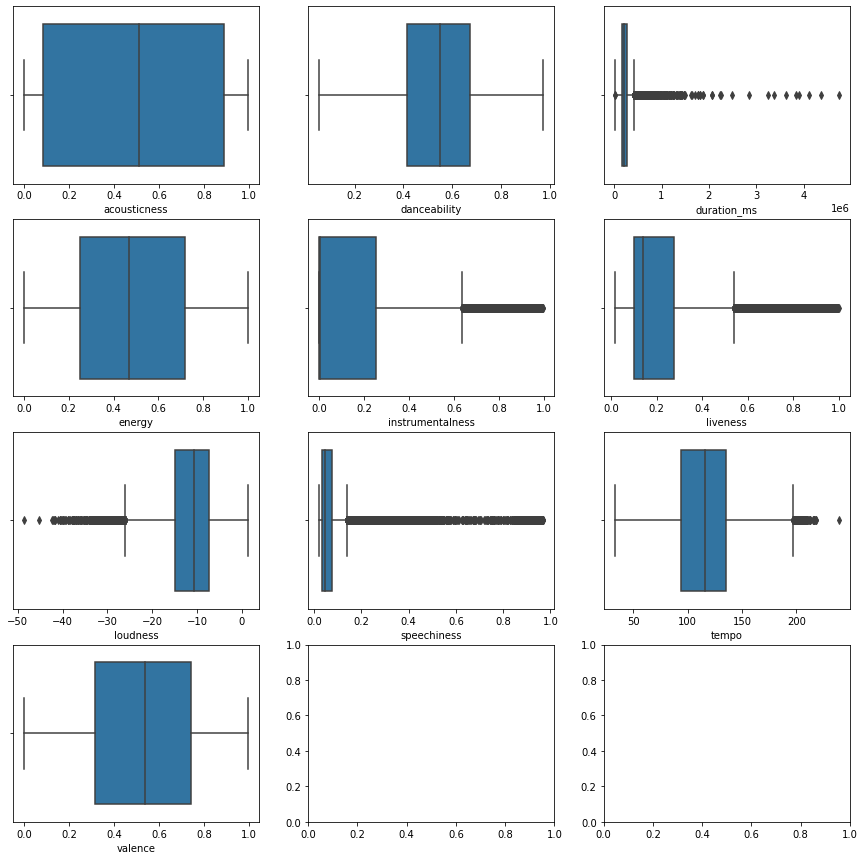

In [65]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

features_to_plot = numerical_features[:-3]
features_to_plot.remove('popularity')

for feature_name, ax in zip(features_to_plot, axes.flatten()):
    sns.boxplot(X_train[feature_name], ax=ax)

In [66]:
ct = ColumnTransformer(
    transformers=[
        ('drop_id_and_song_name', 'drop', ['id', 'name']),
        ('min_max_scaler', MinMaxScaler(), ['duration_ms', 'acousticness', 'danceability', 'energy', 'valence']),
        ('robust_scaler', RobustScaler(), ['instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']),
        ('key_encoding', OneHotEncoder(), ['key']),
        ('release_year', ReleaseYearTransformer(), ['release_date'])
    ],
    remainder='passthrough'
)

In [67]:
preproc = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct)
    ]
)

In [68]:
preproc.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])]))])

In [69]:
pd.DataFrame(preproc.transform(X_train)).head()

0         1         2         3         4         5         6   \
0  0.011642  1.000000  0.647097  0.466989  0.577889  2.765811  2.158314   
1  0.044118  0.089960  0.240823  0.945999  0.455276 -0.001906  1.275626   
2  0.040442  0.655622  0.574120  0.508990  0.677387 -0.001869 -0.430524   
3  0.056697  0.158635  0.671060  0.591992  0.491457  0.011717 -0.148064   
4  0.033592  0.052209  0.500054  0.894998  0.228141  0.001008 -0.259112   

         7          8         9   ...   16   17   18   19   20   21      22  \
0 -0.608731  14.169492 -0.365450  ...  0.0  0.0  0.0  0.0  0.0  0.0  1998.0   
1  0.804970   1.360775  1.452679  ...  0.0  0.0  0.0  0.0  0.0  0.0  1986.0   
2  0.165615  -0.336562 -0.694174  ...  0.0  0.0  0.0  1.0  0.0  0.0  1974.0   
3  0.482069  -0.355932  0.286951  ...  0.0  0.0  0.0  0.0  0.0  1.0  2008.0   
4  0.606447   0.871671 -0.454508  ...  0.0  0.0  0.0  0.0  0.0  0.0  2020.0   

    23   24         25  
0  1.0  1.0  46.117647  
1  0.0  0.0  34.333333  
2  0.0  1.0  29.125000  
3  0.0  0.0  53.000000  
4  0.0  1.0   1.000000  

[5 rows x 26 columns]

In [70]:
col_number = pd.DataFrame(preproc.transform(X_train)).shape[1]

#### Save your results

Run the following cell to save your results.

In [71]:
# Print below your preproc here for the correctors
from sklearn import set_config; set_config(display='diagram')
preproc

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])]))])

In [72]:
from nbresult import ChallengeResult

ChallengeResult(
    "c6_preprocessing",
    col_number=col_number
).write()

## Training

📝 Time to optimize 

- **Add an estimator to your pipeline (only from scikit-learn)** 

- **Train your pipeline and fine-tune (optimize) your estimator to get the best prediction score**

- **You must create 2 pipelines (one with a linear model, one with an ensemble model)**

Then, 

- Save your two best 5-time cross-validated scores as _float_: `score_linear` and `score_ensemble`

- Save your two best trained pipelines as _Pipeline_ objects: `pipe_linear` and `pipe_ensemble`

### Linear

In [98]:
linear_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('linear_model', Lasso())
    ]
)

In [99]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])])),
                ('linear_model', Lasso())])

In [100]:
y_pred = linear_pipeline.predict(X_test)

rmse_linear_not_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_linear_not_tuned)

14.356731368795595


In [109]:
param_grid = {
    'linear_model__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
}

In [110]:
linear_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('linear_model', Lasso())
    ]
)

grid_search = GridSearchCV(
    linear_pipeline, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5, 
    verbose=1,
    refit=True , 
    n_jobs=-1
)

In [111]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.6s finished


CPU times: user 2.25 s, sys: 156 ms, total: 2.41 s
Wall time: 12.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('artist_popularity',
                                        ArtistPopularityTransformer()),
                                       ('scaling_and_additional_preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop_id_and_song_name',
                                                                         'drop',
                                                                         ['id',
                                                                          'name']),
                                                                        ('min_max_scaler',
                                                                         MinMaxScaler(),
                                                                         ['duration_ms',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'energy',
                                                                          'valence']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo']),
                                                                        ('key_encoding',
                                                                         OneHotEncoder(),
                                                                         ['key']),
                                                                        ('release_year',
                                                                         ReleaseYearTransformer(),
                                                                         ['release_date'])])),
                                       ('linear_model', Lasso())]),
             n_jobs=-1,
             param_grid={'linear_model__alpha': [0.001, 0.005, 0.01, 0.05, 0.1,
                                                 0.5, 1, 2]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [112]:
grid_search.best_params_

{'linear_model__alpha': 0.001}

In [113]:
- grid_search.best_score_

14.789973364561174

In [114]:
y_pred = grid_search.best_estimator_.predict(X_test)

rmse_linear_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_linear_not_tuned)

14.356731368795595


### Ensemble

In [117]:
# XGBRegressor is not a Scikit-Learn model but the class follows the same syntax as a Scikit-Learn estimator
ensemble_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('ensemble_model', XGBRegressor())
    ]
)

In [118]:
ensemble_pipeline.fit(X_train, y_train)

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instru...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [121]:
y_pred = ensemble_pipeline.predict(X_test)

rmse_ensemble_not_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_ensemble_not_tuned)

12.693176286711802


In [125]:
param_distributions = {
    'ensemble_model__n_estimators': randint(50, 150),
    'ensemble_model__max_depth': randint(5, 25),
    'ensemble_model__learning_rate': uniform(0.05, 0.3),
    'ensemble_model__min_child_weight': randint(1, 7),
    'ensemble_model__gamma': uniform(0, 0.5),
    'ensemble_model__reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'ensemble_model__booster': ['gbtree', 'gblinear', 'dart']
}

In [138]:
ensemble_pipeline = Pipeline(
    steps=[
        ('artist_popularity', ArtistPopularityTransformer()),
        ('scaling_and_additional_preprocessing', ct),
        ('ensemble_model', XGBRegressor())
    ]
)

random_search = RandomizedSearchCV(
    ensemble_pipeline, 
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5, 
    verbose=1,
    refit=True , 
    n_jobs=-1
)

In [139]:
%%time

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.5min finished


CPU times: user 37.2 s, sys: 1.14 s, total: 38.3 s
Wall time: 19min 38s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('artist_popularity',
                                              ArtistPopularityTransformer()),
                                             ('scaling_and_additional_preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('drop_id_and_song_name',
                                                                               'drop',
                                                                               ['id',
                                                                                'name']),
                                                                              ('min_max_scaler',
                                                                               MinMaxScaler(),
                                                                               ['duration_ms',
                                                                                'acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'valence']),
                                                                              ('robu...
                                        'ensemble_model__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f44d10>,
                                        'ensemble_model__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f46210>,
                                        'ensemble_model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131f44c50>,
                                        'ensemble_model__reg_alpha': [1e-05,
                                                                      0.01, 0.1,
                                                                      1, 100]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [143]:
random_search.best_params_

{'ensemble_model__booster': 'gbtree',
 'ensemble_model__gamma': 0.3364093010602823,
 'ensemble_model__learning_rate': 0.12423312668551885,
 'ensemble_model__max_depth': 14,
 'ensemble_model__min_child_weight': 6,
 'ensemble_model__n_estimators': 110,
 'ensemble_model__reg_alpha': 100}

In [144]:
- random_search.best_score_

13.202002312127174

In [145]:
y_pred = random_search.best_estimator_.predict(X_test)

rmse_ensemble_tuned = mean_squared_error(y_test, y_pred, squared=False)

print(rmse_ensemble_tuned)

12.682370740213036


### Save your results

Run the following cell to save your results.

In [146]:
pipe_linear = grid_search.best_estimator_
pipe_ensemble = random_search.best_estimator_

In [147]:
score_linear = rmse_linear_tuned
score_ensemble = rmse_ensemble_tuned

In [148]:
# Print below your best pipe for correction purpose
from sklearn import set_config; set_config(display='diagram')
pipe_linear

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('key_encoding',
                                                  OneHotEncoder(), ['key']),
                                                 ('release_year',
                                                  ReleaseYearTransformer(),
                                                  ['release_date'])])),
                ('linear_model', Lasso(alpha=0.001))])

In [149]:
# Print below your best pipe for correction purpose
pipe_ensemble

Pipeline(steps=[('artist_popularity', ArtistPopularityTransformer()),
                ('scaling_and_additional_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_id_and_song_name',
                                                  'drop', ['id', 'name']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'valence']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['instru...
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.12423312668551885,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=6, missing=nan,
                              monotone_constraints='()', n_estimators=110,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=100, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [150]:
from nbresult import ChallengeResult

ChallengeResult("c8_c9_c11_c13_model_tuning",
    scoring = scoring,
    score_linear=score_linear,
    score_ensemble=score_ensemble).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**